In [6]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from copy import deepcopy
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from pandeia.engine.perform_calculation import perform_calculation

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [7]:
array_dir = os.path.join(array_dir, 'sample_skypy_lens')
pickle_dir = os.path.join(pickle_dir, 'pyhalo')

# Generate images with various PSFs

In [8]:
lens = SampleSkyPyLens()

num_pix = 45
side = 4.95
band = 'f184'

## Grab default substructure

In [9]:
# add CDM subhalos; NB same subhalo population for all
lens.add_subhalos(*pyhalo.unpickle_subhalos(os.path.join(pickle_dir, 'cdm_subhalos_tuple')))

## No PSF

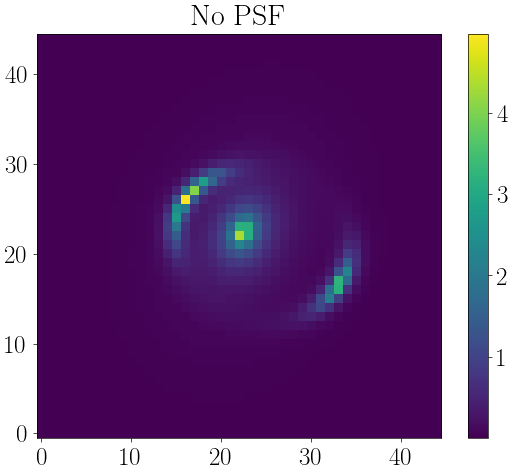

(45, 45)


In [10]:
no_psf_lens = deepcopy(lens)

kwargs_psf_none = {'psf_type': 'NONE'}

no_psf = no_psf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_none, side=side)

plot.plot(title='No PSF',
          array=no_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'no_psf.npy'), no_psf)

print(no_psf.shape)

## Gaussian PSF

I'm getting the PSF FWHM values from [here](https://roman.gsfc.nasa.gov/science/WFI_technical.html). From that webpage: "Note: PSF FWHM in arcseconds simulated at the center of the center pixel of a detector near the center of the WFI FOV using an input spectrum for a K0V type star."

In [11]:
psf_fwhm = {
    'f062': 0.058,
    'f087': 0.073,
    'f106': 0.087,
    'f129': 0.105,
    'f158': 0.127,
    'f184': 0.151,
    'f213': 0.175,
    'f146': 0.105
}

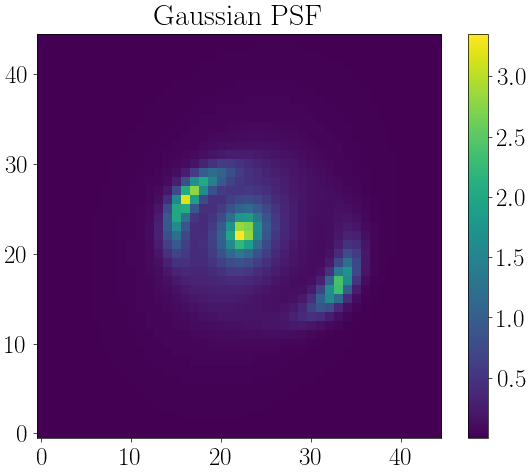

(45, 45)


In [12]:
gaussian_psf_lens = deepcopy(lens)

kwargs_psf_gaussian = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm.get(band)}

gaussian_psf = gaussian_psf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_psf_gaussian, side=side)

plot.plot(title='Gaussian PSF',
          array=gaussian_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'gaussian_psf.npy'), gaussian_psf)

print(gaussian_psf.shape)

## WebbPSF

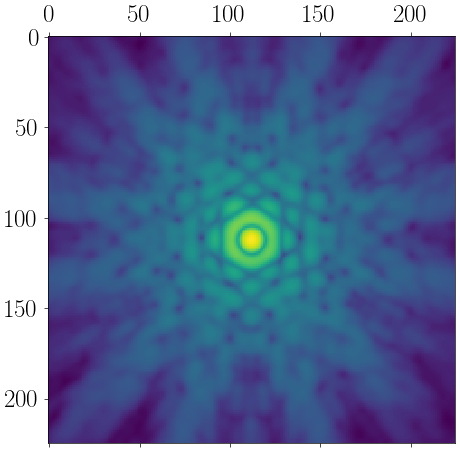

In [13]:
import astropy.io.fits as pyfits

# load PSF from WebbPSF
psf_filename = os.path.join(repo_dir, 'mejiro', 'data', 'webbpsf_f184.fits')
kernel = pyfits.getdata(psf_filename)
plt.matshow(np.log10(kernel))
plt.show()

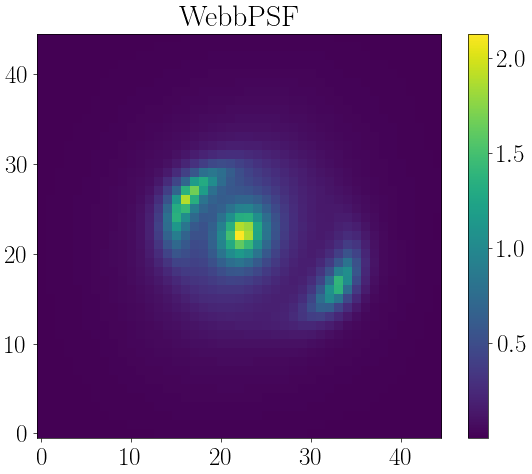

(45, 45)


In [14]:
webbpsf_lens = deepcopy(lens)

kwargs_webbpsf = {
    'psf_type': 'PIXEL',
    'kernel_point_source': kernel,
    'point_source_supersampling_factor': 5
    }

webbpsf_psf = webbpsf_lens.get_array(num_pix=num_pix, kwargs_psf=kwargs_webbpsf, side=side)

plot.plot(title='WebbPSF',
          array=webbpsf_psf,
          colorbar=True)

np.save(os.path.join(array_dir, 'webbpsf.npy'), webbpsf_psf)

print(webbpsf_psf.shape)

# Plot

In [15]:
no_psf = np.load(os.path.join(array_dir, 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'gaussian_psf.npy'))
pandeia = np.load(os.path.join(array_dir, 'webbpsf.npy'))

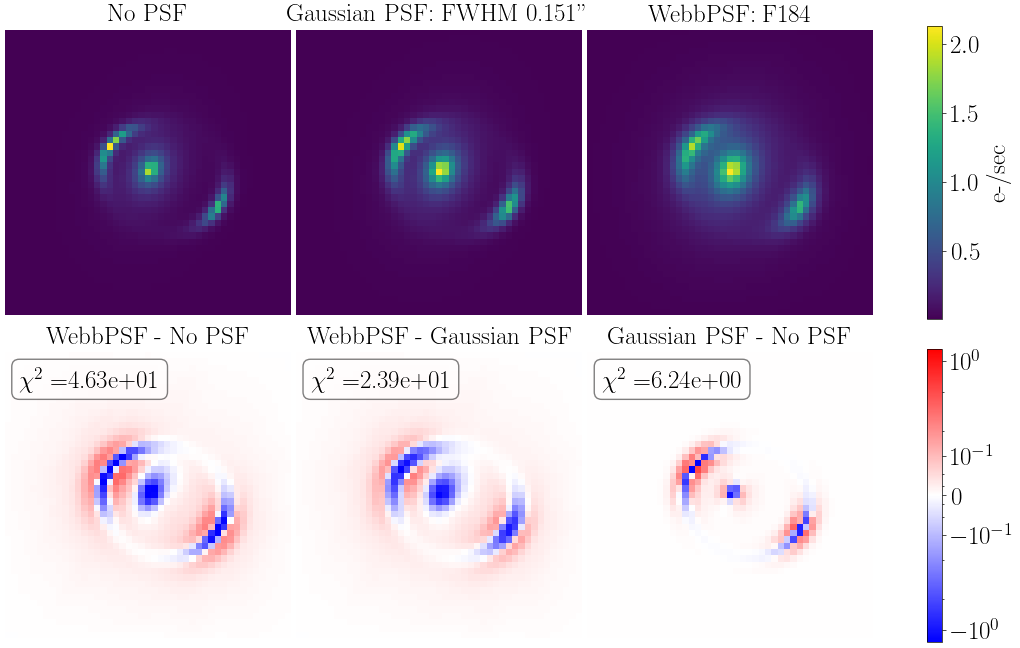

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.02})

fontsize = 18

matplotlib.rcParams.update({'font.size': fontsize})

array_list = [no_psf, gaussian_psf, pandeia]
title_list = ['No PSF', f'Gaussian PSF: FWHM {psf_fwhm.get(band)}"', 'WebbPSF: F184']

for i, array in enumerate(array_list):
    axis_1 = ax[0][i].imshow((array), cmap='viridis')
    ax[0][i].set_title(title_list[i], fontsize=fontsize)
    ax[0][i].set_axis_off()

cbar = fig.colorbar(axis_1, ax=ax[0])
cbar.set_label('e-/sec', rotation=90)

# normalized_no_psf = stats.normalize(no_psf)
# normalized_gaussian_psf = stats.normalize(gaussian_psf)
# normalized_pandeia = stats.normalize(pandeia)

# array_list = [normalized_pandeia - normalized_no_psf, normalized_pandeia - normalized_gaussian_psf, normalized_gaussian_psf - normalized_no_psf]
array_list = [pandeia - no_psf, pandeia - gaussian_psf, gaussian_psf - no_psf]
title_list = ['WebbPSF - No PSF', 'WebbPSF - Gaussian PSF', 'Gaussian PSF - No PSF']

# compute mean chi square
chi_square_list = []
chi_square_list.append(stats.chi_square(no_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, pandeia))
chi_square_list.append(stats.chi_square(gaussian_psf, no_psf))
chi_square_list = ['$\chi^2 = $' + '{:.2e}'.format(i) for i in chi_square_list]

norm = plot_util.get_norm(array_list, linear_width=0.1)

for i, array in enumerate(array_list):
    axis_2 = ax[1][i].imshow(array, cmap='bwr', norm=norm)
    ax[1][i].set_title(title_list[i], fontsize=fontsize)
    ax[1][i].set_axis_off()

overplot.text_boxes(ax[1], chi_square_list, fontsize=fontsize)

fig.colorbar(axis_2, ax=ax[1], ticks=[-1, -10** -1, 0, 10 ** -1, 1])

plt.savefig(os.path.join(figure_dir, 'psf_compare.png'))
plt.show()

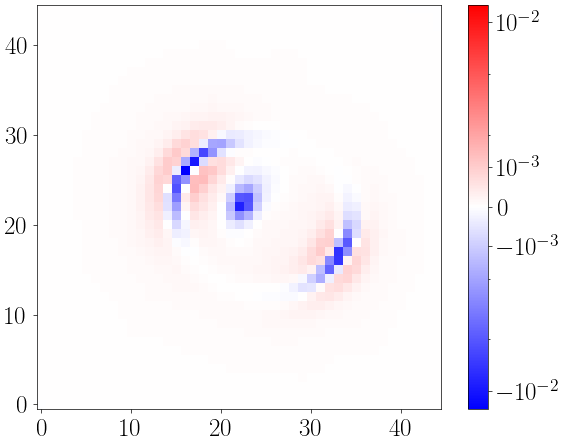

In [17]:
diagnostic_plot.residual(stats.normalize(pandeia), stats.normalize(no_psf))

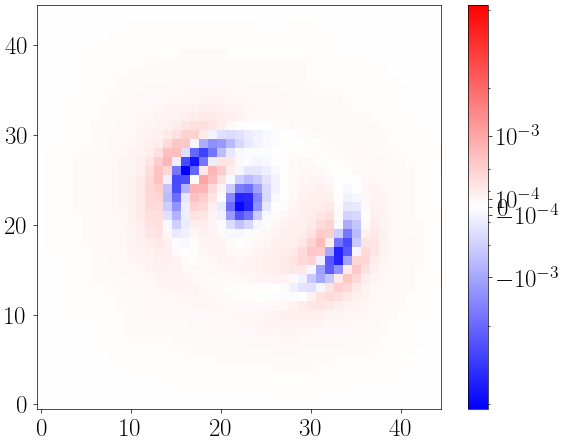

In [18]:
diagnostic_plot.residual(stats.normalize(pandeia), stats.normalize(gaussian_psf))

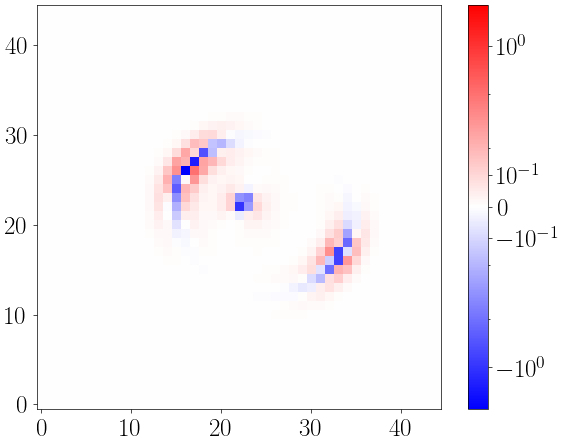

In [19]:
diagnostic_plot.residual(pandeia - no_psf, pandeia - gaussian_psf)